# Basic Tutorial for <font color='green'> Toad</font>


Toad is developed to facilitate the model development of credit risk scorecard particularly. In this tutorial, the basic use of toad will be introduced. 

______
______

The tutorial will follow the common procedure of credit risk scorecard model development: 



**(1) EDA**

**(2) Feature selection and WOE binning**

**(3) Model selection**

**(4) Model validation**

**(5) Scorecard transformation**

### 0. Data preparation
The data used is the famous german credit dataset. The following data preprocessing include: 

(1) replacing target as 0, 1 from 'good' / 'bad';

(2) train test split; 

and (3) adding a feature to indicate train and test. The training set will be used for modelling and the test set will only be used for validation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import toad

In [2]:
data = pd.read_csv('germancredit.csv')
data.replace({'good':0,'bad':1},inplace=True) # replace target as 0, 1. 

print(data.shape) # 1000 data and 20 features 
data.head()

(1000, 21)


,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,personal.status.and.sex,other.debtors.or.guarantors,...,property,age.in.years,other.installment.plans,housing,number.of.existing.credits.at.this.bank,job,number.of.people.being.liable.to.provide.maintenance.for,telephone,foreign.worker,creditability
0,... < 0 DM,6,critical account/ other credits existing (not ...,radio/television,1169,unknown/ no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,1
2,no checking account,12,critical account/ other credits existing (not ...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,none,yes,0
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,1


In [3]:
Xtr,Xts,Ytr,Yts = train_test_split(data.drop('creditability',axis=1),data['creditability'],test_size=0.25,random_state=450)
data_tr = pd.concat([Xtr,Ytr],axis=1)
data_tr['type'] = 'train'
data_ts = pd.concat([Xts,Yts],axis=1)
data_ts['type'] = 'test'

# The training set will be used for modelling and the test set will only be used for validation. 

print(data_tr.shape)
#print(data_tr.head())

(750, 22)


___
----
### I. EDA data handling
Toad supports general EDA of each feature to detect missing values and feature distribution.

1. **toad.detector.detect()**: return the EDA report of each feature, incl. data type, distribution, missing rate, and unique values. The EDA report is aimed to guide missing / extreme value detection & replacing.

In [4]:
toad.detector.detect(data_tr).head(10)
# change into mode, 2nd mode, missing

,type,size,blank,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
status.of.existing.checking.account,object,750,0.00%,4,no checking account:39.20%,... < 0 DM:27.60%,0 <= ... < 200 DM:27.07%,... >= 200 DM / salary assignments for at leas...,None,None,no checking account:39.20%,... < 0 DM:27.60%,0 <= ... < 200 DM:27.07%,... >= 200 DM / salary assignments for at leas...
duration.in.month,int64,750,0.00%,32,20.548,11.941,4,6,8,18,24,36,60,72
credit.history,object,750,0.00%,5,existing credits paid back duly till now:53.73%,critical account/ other credits existing (not ...,delay in paying off in the past:8.00%,all credits at this bank paid back duly:4.93%,no credits taken/ all credits paid back duly:3...,existing credits paid back duly till now:53.73%,critical account/ other credits existing (not ...,delay in paying off in the past:8.00%,all credits at this bank paid back duly:4.93%,no credits taken/ all credits paid back duly:3...
purpose,object,750,0.00%,10,radio/television:27.47%,car (new):25.33%,furniture/equipment:18.40%,business:9.33%,car (used):9.20%,education:5.07%,repairs:2.67%,domestic appliances:1.07%,others:0.93%,retraining:0.53%
credit.amount,int64,750,0.00%,700,3207.35,2731.93,250,417.33,906.3,2301.5,3956.5,7179.4,12715.2,15672
savings.account.and.bonds,object,750,0.00%,5,... < 100 DM:60.93%,unknown/ no savings account:17.47%,100 <= ... < 500 DM:10.53%,500 <= ... < 1000 DM:6.00%,... >= 1000 DM:5.07%,... < 100 DM:60.93%,unknown/ no savings account:17.47%,100 <= ... < 500 DM:10.53%,500 <= ... < 1000 DM:6.00%,... >= 1000 DM:5.07%
present.employment.since,object,750,0.00%,5,1 <= ... < 4 years:32.53%,... >= 7 years:24.93%,... < 1 year:18.67%,4 <= ... < 7 years:17.60%,unemployed:6.27%,1 <= ... < 4 years:32.53%,... >= 7 years:24.93%,... < 1 year:18.67%,4 <= ... < 7 years:17.60%,unemployed:6.27%
installment.rate.in.percentage.of.disposable.income,int64,750,0.00%,4,2.94533,1.13493,1,1,1,3,4,4,4,4
personal.status.and.sex,object,750,0.00%,3,male : single:54.40%,female : divorced/separated/married:36.27%,male : married/widowed:9.33%,None,None,None,None,male : single:54.40%,female : divorced/separated/married:36.27%,male : married/widowed:9.33%
other.debtors.or.guarantors,object,750,0.00%,3,none:90.80%,guarantor:4.93%,co-applicant:4.27%,None,None,None,None,none:90.80%,guarantor:4.93%,co-applicant:4.27%


---
---
### II. Feature selection, fine classing, and WOE transformation

Toad can be used to filter abundant features such as the ones with high missing rate, low iv, and highly correlated features. It can also fine class features with vairous binning techniques and apply WOE transformation.

----
1. **toad.selection.select()**:  used to filter features based on missing percentage, iv (with 20 bins), and multicolleanrity (with VIF and/or intercorrelation) 

In [5]:
# The filter criteria include missing rate >=0.5, iv <= 0.05, correlation >= 0.7 (the one with the hightest iv will be kept), 
# and "exclude = ['type']" specifies that 'type' tag will be not dropped
selected_data, drop_lst= toad.selection.select(data_tr,target = 'creditability', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['type'])

selected_test = data_ts[selected_data.columns]

print(selected_data.shape)
drop_lst # As shown, 8 features have been dropped due to low iv. 

(750, 16)


{'empty': array([], dtype=float64),
 'iv': array(['installment.rate.in.percentage.of.disposable.income',
        'present.residence.since',
        'number.of.existing.credits.at.this.bank', 'job',
        'number.of.people.being.liable.to.provide.maintenance.for',
        'telephone'], dtype=object),
 'corr': array([], dtype=object)}

-------
2. **toad.quality(dataframe, target)**: return the quality of each feature, incl. iv, gini, and entropy. The output provides information of which features are potentially more useful. 

In [6]:
quality = toad.quality(data,'creditability').sort_values(by='iv',ascending=False)
quality.head(6)

,iv,gini,entropy,unique
status.of.existing.checking.account,0.666012,0.368037,0.545196,4.0
credit.amount,0.544812,0.408680,0.610864,921.0
duration.in.month,0.345412,0.406755,0.609659,33.0
credit.history,0.293234,0.394090,0.580631,5.0
age.in.years,0.243195,0.414339,0.610863,53.0
savings.account.and.bonds,0.196010,0.404838,0.591377,5.0


__________
---
First, Combiner() to bin and set bins

3. **toad.transform.Combiner()**: combiner is used to fine class numerical and categorical features with binning. We support Chi-squared binning, decision tree binning, binning by step, and binning by quantile. _The following demonstrates the procedure._

3.1. **combiner().fit(**data, y = 'target', method = 'chi', min_samples = None, n_bins = None** )**: fit binning. Method supports 'chi', 'dt', 'percentile', and 'step'.

3.2. **combiner().set_rules(**dict**)**: used to set bins.

3.3. **combiner().transform(**data**)**: transform the features of data into binned groups. 
____
Second, WOETransformer() to WOE transform

4. **toad.transform.WOETransformer()**: apply WOE transformation after binnning

4.1 **WOETransformer().fit_transform(**data, y_true, exclude = None**)**: WOE transform data by data. "exclude" excludes the columns not to be transformed 

4.2 **WOETransformer().transform(**data**)

-----
Use plots to tune bins. 

5. **toad.plot.badrate_plot(**data,target = 'target', x = None, by = None**)**: plot the bad rate of each bin across different sets. Different sets can be train/test, or different month etc. "by" is name of the column to plot. "x" is the column used for comparison (e.g.month, test/train).
6. **toad.plot.proportion_plot(**data[col]**)**: plot the proportion each bin of a binned feature.

Note: the guide below is the binning as a whole, please refer to the [complete tutorial]() for bins adjustment. (TBA)

In [7]:
# Step 1: initialise a combiner class
combiner = toad.transform.Combiner()

# Step 2: fit data and specify binningm method along with other parameters (optional)
min_samples = 0.05 * data.shape[0] # specify that minimum number of samples is at least 5% of all data 
combiner.fit(selected_data,y='creditability',method='chi',min_samples = min_samples) # fit binning 

# Step 3: save bins. The bins are saved as a dictionary. 
bins = combiner.export() 

print('Step 3 ')
print('status.of.existing.checking.account:',bins['status.of.existing.checking.account'])
print('credit.amount:',bins['credit.amount'])
print('duration.in.month:', bins['duration.in.month'])

Step 3 
status.of.existing.checking.account: [['no checking account', '... >= 200 DM / salary assignments for at least 1 year'], ['0 <= ... < 200 DM'], ['... < 0 DM']]
credit.amount: [2145, 3914]
duration.in.month: [9, 12, 18, 33]


In [8]:
# Step 4: adjust bins with badrate_plot(). To fine tune the bins, we use a new combiner().

# we want to check the bins of 'duration.in.month'
adj_bin = {'duration.in.month': [8, 18, 45]}

c2 = toad.transform.Combiner()
c2.set_rules(adj_bin)

data_ = pd.concat([data_tr,data_ts],axis = 0)
temp_data = c2.transform(data_[['duration.in.month','creditability','type']])

# plot shows stability across train and test
from toad.plot import badrate_plot, proportion_plot
badrate_plot(temp_data, target = 'creditability', x = 'type', by = 'duration.in.month') 
proportion_plot(temp_data['duration.in.month'])

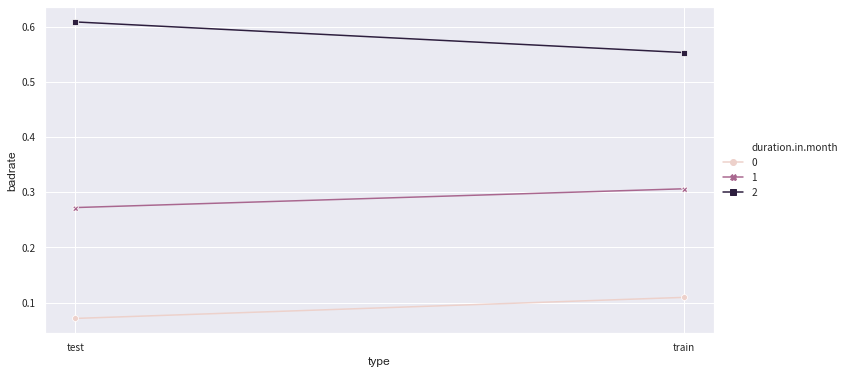

In [9]:
# Assume we want to combine bin #1 and #2 are close
adj_bin = {'duration.in.month': [8, 45]}
c2.set_rules(adj_bin)

temp_data = c2.transform(data_[['duration.in.month','creditability','type']])
badrate_plot(temp_data, target = 'creditability', x = 'type', by = 'duration.in.month')
# therefore use this 

In [10]:
# Step 5: WOE transform with adjusted bins 
combiner.set_rules(adj_bin)
binned_data = combiner.transform(selected_data)

transer = toad.transform.WOETransformer()
data_tr_woe = transer.fit_transform(binned_data, binned_data['creditability'], exclude=['creditability'])

data_ts_woe = transer.transform(combiner.transform(selected_test))

-----------
---
### III. Model selection
1. **toad.selection.stepwise()**: this function performs feature selection (or model selection formally) with forward / backward / both-way stepwise. The function uses AIC / BIC as selection criterion.

In [11]:
final_data = toad.selection.stepwise(data_tr_woe,target = 'creditability',direction = 'both', criterion = 'aic')

final_test = data_ts_woe[final_data.columns]
print(final_data.shape)
print(final_data.columns) # As shown, 15 features are down to 12 after both-way stepwise 

(750, 13)
Index(['credit.amount', 'status.of.existing.checking.account', 'age.in.years',
       'duration.in.month', 'purpose', 'other.installment.plans',
       'other.debtors.or.guarantors', 'credit.history',
       'savings.account.and.bonds', 'property', 'present.employment.since',
       'foreign.worker', 'creditability'],
      dtype='object')


In [12]:
# Now ready to model. Fit a lr. 
Xtr = final_data.drop('creditability',axis=1)
Ytr = final_data['creditability']
Xts = final_test.drop('creditability',axis=1)
Yts = final_test['creditability']

lr = LogisticRegression()
lr.fit(Xtr, Ytr)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

----
----
### IV. Model evaluation and validation
1. **Common evaluation metrics**: toad. metrics. KS, F1, AUC

In [13]:
from toad.metrics import KS, F1, AUC

EYtr_proba = lr.predict_proba(Xtr)[:,1]
EYtr = lr.predict(Xtr)

print('Training error')
print('F1:', F1(EYtr_proba,Ytr))
print('KS:', KS(EYtr_proba,Ytr))
print('AUC:', AUC(EYtr_proba,Ytr))

EYts_proba = lr.predict_proba(Xts)[:,1]
EYts = lr.predict(Xts)

print('\nTest error')
print('F1:', F1(EYts_proba,Yts))
print('KS:', KS(EYts_proba,Yts))
print('AUC:', AUC(EYts_proba,Yts))

Training error
F1: 0.44766839378238343
KS: 0.5560263137945266
AUC: 0.8465772693963157

Test error
F1: 0.44859813084112155
KS: 0.39424193173902944
AUC: 0.7349276371797849


------
2. **toad.metrics.PSI():** return the PSI of each feature to detect data migration

In [14]:
psi = toad.metrics.PSI(final_data,final_test)
psi.sort_values(0,ascending=False) # Further tune the unstable feature

credit.amount                          6.801442
age.in.years                           0.167607
purpose                                0.102206
duration.in.month                      0.034282
present.employment.since               0.031952
foreign.worker                         0.017705
property                               0.014331
credit.history                         0.013292
savings.account.and.bonds              0.012473
other.debtors.or.guarantors            0.003238
status.of.existing.checking.account    0.001251
creditability                          0.000545
other.installment.plans                0.000370
dtype: float64

----
3. **toad.metrics.KS_bucket(**predicted_proba, y_true, bucket=10, method = 'quantile'**)**: output the result table including bad_rate, KS etc. 

In [15]:
tr_bucket = toad.metrics.KS_bucket(EYtr_proba,Ytr,bucket=10,method='quantile')
tr_bucket

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,cum_bads,cum_goods,cum_bads_prop,cum_goods_prop,ks
0,0.004769,0.032889,0,75,75,0.000000,1.000000,0.000000,0.000000,0.143403,0,75,0.000000,0.143403,-0.143403
1,0.033247,0.065360,3,72,75,0.040000,0.960000,0.041667,0.013216,0.137667,3,147,0.013216,0.281071,-0.267855
2,0.065821,0.110402,6,69,75,0.080000,0.920000,0.086957,0.026432,0.131931,9,216,0.039648,0.413002,-0.373354
3,0.110677,0.166014,11,64,75,0.146667,0.853333,0.171875,0.048458,0.122371,20,280,0.088106,0.535373,-0.447267
4,0.166417,0.234390,13,62,75,0.173333,0.826667,0.209677,0.057269,0.118547,33,342,0.145374,0.653920,-0.508545
5,0.241344,0.316216,17,58,75,0.226667,0.773333,0.293103,0.074890,0.110899,50,400,0.220264,0.764818,-0.544554
6,0.316592,0.427541,29,46,75,0.386667,0.613333,0.630435,0.127753,0.087954,79,446,0.348018,0.852772,-0.504755
7,0.429715,0.551697,41,34,75,0.546667,0.453333,1.205882,0.180617,0.065010,120,480,0.528634,0.917782,-0.389148
8,0.552091,0.694043,50,25,75,0.666667,0.333333,2.000000,0.220264,0.047801,170,505,0.748899,0.965583,-0.216684
9,0.694348,0.973512,57,18,75,0.760000,0.240000,3.166667,0.251101,0.034417,227,523,1.000000,1.000000,0.000000


----
----
### V. Scorecard transformation
Toad allows scorecard transformation from bins and convert probability of credit risk into scores accordingly.
1. toad.scorecard.ScoreCard():

1.1 ScoreCard().predict(X): output scores

In [16]:
#TBA